In [1]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from keras.models import load_model
import tensorflow.keras.backend as K
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras
import os
from data_generation import *
from batch_creator import *
from gp_kernels import *
from gp_priors import *
from gp_plots import *

Using TensorFlow backend.


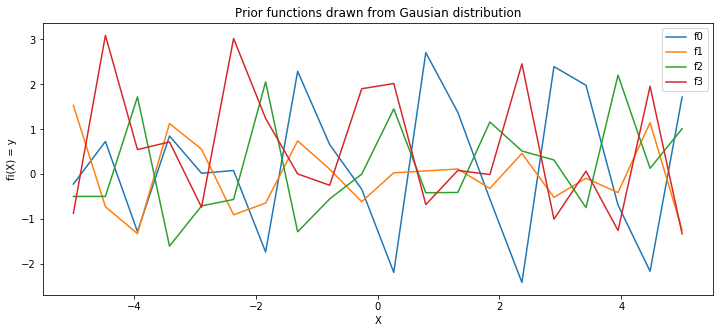

In [2]:
plot_gp_prior(4, n=20)

In [3]:
def create_batch_gp_mim_2(pos, tar, pos_mask, batch_s=128):
    '''
    Get a batch of positions, targets and position mask from data generated 
    by data_generator_for_gp_mimick_gpt function and from position_mask function 
    -------------------------
    Parameters:
    pos (2D np array): 1st/2nd output from data_generator_for_gp_mimick_gpt function 
    tar (2D np array): 3rd/4th output from data_generator_for_gp_mimick_gpt function  
    pos_mask (4D np.array): output from position_mask function 
    batch_s (int): deafult 128
    -------------------------
    Returns:
    batch_tar_tr (2D np array)
    batch_pos_tr (2D np array)
    batch_pos_mask (4D np array)
    batch_idx_tr (1D np array): indices (=row numbers) chosen for current batch
    
    '''
    shape = tar.shape[0]
    batch_idx_tr = np.random.choice(list(range(shape)), batch_s)
    batch_tar_tr = tar[batch_idx_tr, :]
    batch_pos_tr = pos[batch_idx_tr, :]
    batch_pos_mask = pos_mask[batch_idx_tr, :, :, :]
    return batch_tar_tr, batch_pos_tr, batch_pos_mask, batch_idx_tr

In [4]:
def data_generator_for_gp_mimick_gpt(num_obs, kernel, tr_percent=0.8):
    '''
    Generator for training a GPT inspired netowrk. Make sure x is drawn in a range that 
    Doesn't include 0 --> 0 is used for padding.
    -----------------------
    Parameters:
    num_obs (int): how many observation to generate
    kernel (function of am SKlearn kernel object): e.g. rbf_kernel which comes from gp_kernels file
    tr_percent (float): daefult 0.8
    -----------------------
    Returns:
    pad_pos_tr (np array): the first rows * tr_percent from the x generated values padded by zeros according to obs_per_sample  
    pad_pos_te (np array): all rows of x not chosen for training 
    pad_y_fren_tr (np array): the first rows * tr_percent from the f_prior generated values padded by zeros according to obs_per_sample  
    pad_y_fren_te (np array): all rows of f_prior not chosen for training 
    '''
    # 59 is max_seq_len (to change, change 60 to a different number)
    obs_per_sample = np.random.randint(20, 60, size = num_obs)
    df = np.zeros((num_obs * 2, np.max(obs_per_sample)))
    for i in range(0, num_obs * 2, 2):
        x = np.random.uniform(5, 15, size=(1, obs_per_sample[int(i / 2)]))
        k = kernel(x)
        f_prior = generate_priors(k, obs_per_sample[int(i / 2)], 1)

        df[i, :x.shape[1]] = x
        df[i + 1, :x.shape[1]] = f_prior

    rows = df.shape[0]
    cols = df.shape[1]
    tr_rows = int(tr_percent * rows)
    tr_rows = tr_rows if tr_rows % 2 == 0 else tr_rows + 1
    df_tr = df[:tr_rows, :]
    df_te = df[tr_rows:, :]
    
    # get all even rows
    pad_pos_tr = df_tr[::2, :]
    pad_pos_te = df_te[::2, :]
    # get all odd rows
    pad_y_fren_tr = df_tr[1::2, :]
    pad_y_fren_te = df_te[1::2, :]

    return pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, df_tr, df_te

In [5]:
def position_mask(arr):
    '''
    This tries to emulate the kernel matrix. 
    In the first stage we have a 2X2 matrix of ones, next
    3X3 matrix of ones, etc.
    -------------------------
    Parameters:
    arr (np array): the 1st/2nd output from data_generator_for_gp_mimick_gpt function
    -------------------------
    Returns:
    mask (4D np array): if there are 100 rows and 50 cols in arr then this will 
    return [100, 49, 50, 50] array -- where the first dim is observation number 
    second dim is timestamp and third+fourth dim are the mask matrix.
    '''
    rows = arr.shape[0]
    cols = arr.shape[1]
    mask = np.zeros((rows, cols - 1, cols, cols))
    specific = np.sum(np.equal(arr, 0), 1)
    for i in range(2, cols + 1):
        mask[:, i - 2, :i, :i] = np.ones((i, i))
    for j in range(rows):
        k  = specific[j]
        mask[j, k:, :, :] = 0
            
    return mask

In [6]:
def create_padding_mask(seq):
    '''
    Used to pad sequences that have zeros where there was no event.
    Typically this will be combined with create_look_ahead_mask function.
    This function is used inside an open session of tensorflow. 
    To try it out create a tf.constant tensor.
    -------------------
    Parameters:
    seq (tensor): shape is (batch_size, seq_len)
    
    -------------------
    Returns:
    A binary tensor  (batch_size, 1, seq_len): 1 where there was no event and 0 otherwise.
    
    '''
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention. Extra dimension is used in create_masks function
    return seq[:, tf.newaxis, :]  

In [7]:
def create_tar_mask(size):
    '''
    '''
    mask = tf.linalg.diag(tf.ones(size, size))
    return mask

In [8]:
create_tar_mask(3)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=int32)>

In [9]:
def create_look_ahead_mask(size):
    '''
    Hide future outputs from a decoder style network.
    Used typically together with create_padding_mask function
    -----------------------
    Parameters:
    size (int): max sequnce length 
    
    -----------------------
    Returns:
    mask (tensor): shape is (seq_len X seq_len). Example: if size is 4, returns
    0 1 1 1
    0 0 1 1
    0 0 0 1
    0 0 0 0 
    where 1 signifies what to hide.
    '''
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [10]:
def create_masks(tar):
    '''
    Create unified masking hiding future from current timestamps and hiding paddings. 
    -------------------
    Parameters: 
    tar (tensor): batch of padded target sequences 
    -------------------
    Returns: 
    combined_mask_tar  (tensor): shape is batch_size X max_seq_len X max_seq_len
    '''
    
    tar_padding_mask = create_padding_mask(tar)
    ## this will be batch_size X 1 X 40

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    # if max seq length is 40 -- > this will be 40X40 
    
    
    ## This will also be (64, 40, 40)
    combined_mask_tar = tf.maximum(tar_padding_mask, look_ahead_mask)
    
    
    return combined_mask_tar

In [69]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generator_for_gp_mimick_gpt(10000, rbf_kernel)

In [70]:
pp = position_mask(pad_pos_tr)

In [71]:
pp.shape

(8000, 58, 59, 59)

In [72]:
loss_object = tf.keras.losses.MeanSquaredError()

In [73]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.1)
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [74]:
def loss_function(real, pred):
    '''
    Masked MSE. Since the target sequences are padded, 
    it is important to apply a padding mask when calculating the loss.
    ----------------
    Parameters:
    real (tf.tensor float64): shape batch_size X max_seq_len. True values of sequences.
    pred (tf.tensor float64): shape batch_size X max_seq_len. Predictions from GPT network. 
    
    ----------------
    Returns: 
    loss value (tf.float64)
    '''
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
#     print('loss_ :', loss_)
#     shape= (128X58)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [75]:
def dot_prod_position(q, k, mask):
    '''
    Used to create a pseudo XX^T covariance matrix for each 
    positional sequence in the batch.
    ------------------
    Parameters: 
    q : shape (batch_size X max_seq_len X 1). Position outptut from create_batch_gp_mim_2 function (or after another Dense layer) 
    k : shape (batch_size X max_seq_len X 1). Position outptut from create_batch_gp_mim_2 function (or after another Dense layer) 
    mask: shape (batch_size X max_seq_len X max_seq_len X max_seq_len). The positional mask created by position_mask function and selected in batch indices 
    
    ------------------
    Returns:
    nl_qk (tf.tensor float64): shape (batch_size X max_seq_len X max_seq_len X max_seq_len).
    Each observation (1st dim) has seq_len timestamps (2nd dim) and each timestamp has an associated
    seq_len X seq_len pseudo covariance matrix (3rd & 4th dims) masked according to the timestamp.
    
    '''
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    nl_qk = tf.cast(tf.nn.relu(matmul_qk), tf.float64) 
    nl_qk = nl_qk[:, tf.newaxis, :, :]
#     print('nl_qk: ', nl_qk)
#     shape=(128, 1, 59, 59)

#     print('pos_mask:', mask)
#     shape=(128, 58, 59, 59)
    if mask is not None:
        nl_qk *= (tf.cast(mask, tf.float64))
    
    return nl_qk

In [76]:
def dot_product_attention(q, k, v, mask):
    '''
    Attention inspired by Transformer (but not the same). The Transformer embeds the 
    target words to q (query), k (key), v (value). So if we have a batch of 128 sequences 
    with max length 40 and embedding layer is 20, we will get shape q = shape k = shape v
    = (128 X  max sequence length X 20). The Transformer then transposes k 
    to get after matmul (128 X max seq X max seq) matrix. We then apply relu layer (unlike in Transformer)
    ---------------------
    Parameters:
    q (tf.tensor float64): shape (batch_size, max_seq_len, 1)
    k (tf.tensor float64): shape (batch_size, max_seq_len, 1)
    v (tf.tensor float64): shape (batch_size, max_seq_len, 1)
    mask (tf.tensor float64): shape (batch_size, max_seq_len, max_seq_len)
    ---------------------
    Returns:
    out_tar: shape (batch_size, max_seq_len, max_seq_len). The sequences after embedding (or Dense layer) weighted by attention_weights. 
    attention_weights : shape (batch_size, max_seq_len, max_seq_len). Weights to assign for each sequence member at each timestamp (2nd dim).
    matmul_qk: shape (batch_size, max_seq_len, max_seq_len)
    
    
    '''
    # similarity
    # q = k = v  shape := (batch_size, max_seq_len - 1, max_seq_len -1)
    matmul_qk = tf.matmul(q, k, transpose_b = True, name = 'qk')
#     print('matmul_qk: ', matmul_qk)
#     shape=(128, 58, 58)
    
    nl_qk = tf.cast(tf.nn.relu(matmul_qk, name = 'nl_qk'), tf.float64) 
#     print('nl_qk: ', nl_qk)
#     shape=(128, 58, 58)
#     nl_qk shape := (batch_size, max_seq_len - 1, max_seq_len - 1)

    # -1e9 will turn the softmax output in this locations to zero
    # this is a good mask as an input for softmax -- we need also masking when 
    # want to use matmul as is 
    
    if mask is not None:
        nl_qk +=  ((tf.cast(mask, tf.float64)) * -1e9)
    
        
#     print('nl_qk after mask: ', nl_qk)
#     shape=(128, 58, 58)
        
     # turn simialrity to scores
    attention_weights = tf.nn.softmax(nl_qk, axis = -1, name = 'attention_weights')
    # Notice that for all the rows where 
    # everything is 0, the masking will turn everything to -inf
    # and the output from the softmax would be 1/num_cols 
    # (try a = tf.constant([-1e9, -1e9, -1e9]), tf.nn.softmax(a))
    # So we can expect an output from these rows which we want to ignore
    # this will be enforced in the masking of the loss function 
    
#     print('attention_weights: ', attention_weights)
#     shape=(128, 58, 58)
   
    # weight values 
    # attention_weights shape := (batch_size, max_seq_len - 1, max_seq_len - 1), 
    # v shape := batch_size X max_seq_len X tar_d_model
    out_tar = tf.matmul(attention_weights, v)
    
#   print('out_tar: ', out_tar)
#   shape=(128, 58, tar_d_model)
    
    return out_tar, attention_weights, matmul_qk

In [77]:
# def point_wise_feed_forward_network(dff):
#     '''
    
#     '''
#     return tf.keras.Sequential([
#       tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
#       tf.keras.layers.Dense(1)  # (batch_size, seq_len, d_model)
#   ])

In [78]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, pos_d_model, tar_d_model, rate, d_att1, d_att2, dff):
        super(Decoder, self).__init__()
        
        self.tar_d_model = tar_d_model
        self.d_att1 = d_att1
        self.d_att2 = d_att2

        
        self.wq = tf.keras.layers.Dense(pos_d_model, name = 'wq')
        self.wk = tf.keras.layers.Dense(pos_d_model, name = 'wk')
        self.wv = tf.keras.layers.Dense(pos_d_model, name = 'wv')
                    
        
        self.hq = tf.keras.layers.Dense(tar_d_model, name = 'hq')
        self.hk = tf.keras.layers.Dense(tar_d_model, name = 'hk')
        self.hv = tf.keras.layers.Dense(tar_d_model, name = 'hv')
        
        self.h = tf.keras.layers.Dense(d_att1, name = 'h')
        self.j = tf.keras.layers.Dense(d_att2, name = 'j')
        self.r = tf.keras.layers.Dense(d_att1, name = 'r')

        
#         self.ffn = point_wise_feed_forward_network(dff)

    #a call method, the layer's forward pass
    def call(self, tar_position, tar_inp, training, pos_mask, tar_mask):
        
        # Adding extra dimension to allow multiplication of 
        # a sequnce with itself. 
        tar_position = tar_position[:, :, tf.newaxis]
        
        q_p = self.wq(tar_position) 
        k_p = self.wk(tar_position)
#       print('q_p: ', q_p)
#       shape=(128, 59, pos_d_model) = (batch_size X max_seq_len X pos_d_model) 
        
        pos_attn1 = dot_prod_position(q_p, k_p, mask = pos_mask)
#       print('pos_attn1 :', pos_attn1)
#       shape=(128, 58, 59, 59)
    
        tar_inp = tar_inp[:, :, tf.newaxis]

        
        q = self.hq(tar_inp) 
        k = self.hk(tar_inp)
        v = self.hv(tar_inp)
        
#       print('q :', q)
#       shape=(128, 58, 58)

        tar_attn1, _, _ = dot_product_attention(q, k, v, tar_mask)
        # tar_attn1 is (batch_size, max_seq_len - 1, tar_d_model)

#         print('tar_attn1 :', tar_attn1)
#         shape=(128, 58, tar_d_model)
        
        tar1 = tf.nn.relu(tf.squeeze(self.r(tar_attn1)), name = 'tar1')

        pos1 = tf.nn.relu(self.h(pos_attn1), name = 'pos1')
        pos1_t = tf.transpose(pos1, perm = [0, 1, 3, 2])
        pos2 = self.j(pos1_t)
        
        position = tf.reshape(pos2, shape = [tf.shape(pos1)[0], tf.shape(pos1)[1]])
        # shape=(128, 58, d_att2)
                
        
#         connector = tf.matmul(position, tar_attn1)     
#         print('connector :', connector)
#         shape=(128, 58, 58)

        out = position + tar1
        
#         print('out :', out)
#         shape=(128, 58)
        
        return out

In [79]:
decoder = Decoder(16, 16, 0.3, 1, 1, 16)

In [80]:
@tf.function
def train_step(pos, tar, pos_mask):
    '''
    A typical train step function for TF2. Elements which we wish to track their gradient
    has to be inside the GradientTape() clause. see (1) https://www.tensorflow.org/guide/migrate 
    (2) https://www.tensorflow.org/tutorials/quickstart/advanced
    ------------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask (np array): see description in position_mask function
    ------------------    
    '''
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    combined_mask_tar = create_masks(tar_inp)
    with tf.GradientTape(persistent=True) as tape:
        pred = decoder(pos, tar_inp, True, pos_mask, combined_mask_tar)
#         print('pred: ')
#         tf.print(pred)

        loss = loss_function(tar_real, pred)

    gradients = tape.gradient(loss, decoder.trainable_variables)
#     tf.print(gradients)
    optimizer.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)
    b = decoder.trainable_weights[0]
    tf.print(tf.reduce_mean(b))

In [81]:
tf.keras.backend.set_floatx('float64')

In [82]:
if __name__ == '__main__':
    EPOCHS = 20
    batch_s  = 128
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    
    for epoch in range(EPOCHS):
        start = time.time()
#         train_loss.reset_states()

        for batch in range(num_batches):
            batch_tar_tr, batch_pos_tr, batch_pos_mask, _ = create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, pp)
            # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
            # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
            train_step(batch_pos_tr, batch_tar_tr, batch_pos_mask)

            if batch % 50 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, train_loss.result()))

        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

-0.14983498414255669
Epoch 1 Batch 0 Loss 6.6742
-0.14145925474659304
-0.13498479176170519
-0.12968130573884681
-0.12519865079084624
-0.12133518216792732
-0.11796119910757356
-0.11498683028421701
-0.11234637613660647
-0.10998983140182028
-0.10787792436925339
-0.10597903411073829
-0.10426718044969717
-0.10272066074302759
-0.10132109437425912
-0.10005273397608072


KeyboardInterrupt: 

In [84]:
decoder.trainable_variables

[<tf.Variable 'decoder_5/wq/kernel:0' shape=(1, 16) dtype=float64, numpy=
 array([[ 0.12217782,  0.35388234,  0.58750279,  0.13390717, -0.882614  ,
         -0.85657992, -0.61138265, -0.65577289, -0.46772186,  0.16409409,
          0.48870679,  0.64687914,  0.00835146,  0.31078138, -0.25137018,
         -0.69168524]])>,
 <tf.Variable 'decoder_5/wq/bias:0' shape=(16,) dtype=float64, numpy=
 array([ 0.49825685,  0.49825681,  0.4982564 ,  0.49825612, -0.49825718,
        -0.49825703, -0.49825467, -0.49825326, -0.49825632,  0.49825714,
         0.49825622,  0.49825708,  0.4982568 ,  0.49825675, -0.49825711,
        -0.49825688])>,
 <tf.Variable 'decoder_5/dense_42/kernel:0' shape=(1, 16) dtype=float64, numpy=
 array([[ 0.19777247,  0.20910918, -0.71043028,  0.31851061,  0.92556932,
          0.8592857 ,  0.59850997,  0.56832769, -0.29664953,  0.09080569,
          0.30810235, -0.87682829,  0.21225505,  0.2231044 , -0.10244067,
          0.80555418]])>,
 <tf.Variable 'decoder_5/dense_42/bia

In [ ]:
df_te[0, 54]

In [ ]:
pos = df_te[0, :].reshape(1, -1)

In [ ]:
tar = df_te[1, :].reshape(1, -1)

In [ ]:
def infer(pos, tar, pos_mask):
    '''
    
    '''
    combined_mask_tar = create_masks(tar)
    out = decoder(pos, tar, False, pos_mask, combined_mask_tar)
    return out

In [ ]:
def inference(pos, tar, max_seq_len, num_steps = 1):
    '''
    
    ------------------
    Parameters:
    pos (2D np array): (n + num_steps) positions 
    tar (2D np array): n targets 
    max_seq_len (int): this has to be the same max seq length as the trained model
    num_steps (int): how many inference steps are required
    ------------------
    Returns:
    tar 
    
    '''
    pos_mask = position_mask(pos)
    current_idx = np.where(pos != 0)[1][-1]  
    
    out = infer(pos, tar[:, :-1], pos_mask)
    print(out)
#     tar = tf.concat((tar, tf.reshape(out[:, current_idx], [1, 1])), axis = 1)
#     if num_steps > 1:
#         inference(pos, tar, max_seq_len, num_steps - 1)
    
    return out
    

In [ ]:
a = inference(pos, tar, 59)

In [ ]:
# tf.data.Dataset(tf.Tensor(pad_pos_tr, value_index = 0 , dtype = tf.float32))